# Zarr + Xarray

In [1]:
%matplotlib inline

import xarray as xr
import zarr
import numpy as np
from dask import compute, delayed, array as da
from dask.distributed import Client

In [4]:
# Make sure to close any existing clients
%%capture --no-stderr client.close()
client = Client()

## Zarr Setup
In order to set up a zarr store for use with xarray, it is important to set certain attributes that xarray reads out of. The most important of these is the `_ARRAY_DIMENSIONS` attribute, which is used to identify coordinates of arrays. A sample setup can be seen below.

In [5]:
store = zarr.DirectoryStore('./xr.zarr')
root = zarr.group(store, overwrite=True)

time = root.create('time', shape=(0,), chunks=(1024,), dtype = '<i4', fill_value = None)
time.attrs['_ARRAY_DIMENSIONS'] = ['time']
time.attrs['calendar'] = 'proleptic_gregorian'
time.attrs['units'] = 'days since 2018-01-1'

lat = root.create('lat', shape=(4096,), chunks=(4096), dtype = '<f8', fill_value = None)
lat.attrs['_ARRAY_DIMENSIONS'] = ['lat']
lat.attrs['units'] = 'degrees_north'
lat[:] = np.linspace(-90,90, num=4096)

lon = root.create('lon', shape=(8192,), chunks = (8192,),  dtype = '<f8', fill_value = None)
lon.attrs['_ARRAY_DIMENSIONS'] = ['lon']
lat.attrs['units'] = 'degrees_east'
lon[:] = np.linspace(-180,180, num=8192)

var = root.create('var', shape=(0,4096,8192), chunks = (9,256,256), dtype = '<i2', fill_value = None)
var.attrs['_ARRAY_DIMENSIONS'] = ['time', 'lat', 'lon']
var.attrs['grid_mapping'] = 'crs'

## Writing data to Zarr
Data can be written to Zarr as follows. The necessary arrays are first resized to accomodate any new data, which is then written using the `dask.array.store` method. The region of the array to write can be specified using a tuple of slices, which can be generated using `np.s_`, as seen below. It is important that the shape of this slice is the same as the shape of the data being written.

In [6]:
# Resize dimensions
var.resize((100, 4096, 8192))
time.resize((100,))
# Generate random new data
new_vars = da.random.randint(0,100, size=(100,4096, 8192), chunks = (100,256,256))
new_times = da.arange(0,100, chunks = (1024,))
new_vars.store(var, region = [np.s_[0:100,:,:]], lock = False)
new_times.store(time, region = [np.s_[0:100]], lock = False)

## Using Xarray for operations and aggregation
Operations on zarr datasets and arrays in Xarray are automatically distributed using dask's scheduler. In the cell below, the mean value is calculated for every cell across time. This operation may take a while, but progress can be seen at http://localhost:8787/status. If necessary, the slice size can be reduced to speed up execution time.

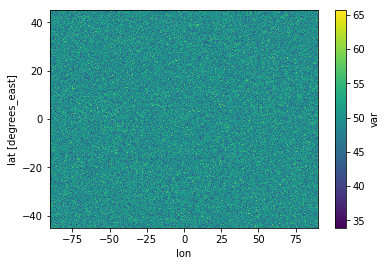

In [11]:
ds = xr.open_zarr(store)
ds['var'].isel(lat=slice(1024,3072), lon=slice(2048,6144)).mean(axis=0).plot()

Similarly, it is possible to get a a timeseries of average value in a specified region, as seen below. 

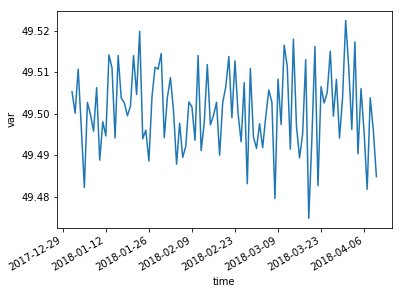

In [12]:
ds['var'].isel(lat=slice(1024,3072), lon=slice(2048,6144)).mean(axis=(1,2)).plot()